# Design Mølmer–Sørensen gates
**Efficient state preparation using Mølmer–Sørensen-type interactions**

The Q-CTRL Python package enables you to efficiently prepare quantum states of trapped ion qubits using Mølmer–Sørensen-type interactions. In this notebook we show how to find optimal and robust control drives to create a (multi-particle) entangled state using the Q-CTRL Python package.

## Imports and initialization

All usage of the Q-CTRL Python package begins by importing the `qctrl` package and starting a session.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qctrlvisualizer import plot_controls

from qctrl import Qctrl

# Starting a session with the API
qctrl = Qctrl()

## Worked example: Optimal control of trapped ions
The interaction Hamiltonian for Mølmer–Sørensen-type operations is in the form of

$$ H(t) = i\frac{\hbar}{2} \sum_{j=1}^N \sigma_{x, j} \sum_{p=1}^{3N} \eta_{pj} \left( 
        \gamma_{j}(t) a_{p}^\dagger - \gamma^\ast_{j}(t) a_p \right)
$$
where $N$ is the number of ions, $\sigma_x$ is the Pauli $X$ operator, $a_p$ is the annihilation operator for the mode $p$, $\eta_{pj}$ is the Lamb–Dicke parameter of mode $p$ for the ion $j$, and $\gamma_j(t)$ is the drive applied ion the ion $j$. 

In this example we consider a chain of three ions (${}^{171}{\rm Yb}^{+}$), and the goal is to find a set of drives such that, at the end of the drives, the relative phase between each ion pair is $\pi/4$. Note that you can perform $X_{\pi/2}$ rotations for all ions after applying the optimal drives to create the GHZ state, as shown in [Kim et al. (2009)](https://doi.org/10.1103/PhysRevLett.103.120502).

### Calculating ion properties
To find the optimal drives, you first need to know the physical properties of the ions, namely the Lamb–Dicke parameters and mode frequencies. You can calculate these values using the function [`calculate_ion_chain_properties`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Functions/calculate_ion_chain_properties.html) by providing basic parameters of your ion trap, specifically the mass of the atom, center of mass (COM) frequencies and laser wave numbers along different axes.

In [2]:
# Specify ion trap parameters
ion_count = 3
atomic_mass = 171

# COM frequencies
radial_x_center_of_mass_frequency = 1.6e6
radial_y_center_of_mass_frequency = 1.5e6
axial_center_of_mass_frequency = 0.3e6

# Laser characteristics
radial_x_wave_number = 1.8e7
radial_y_wave_number = 1.8e7
axial_wave_number = 0

laser_detuning = 1.6047e6
maximum_rabi_rate = 2 * np.pi * 100e3

In [3]:
# Calculate the ions properties
ion_chain_properties = qctrl.functions.calculate_ion_chain_properties(
    atomic_mass=atomic_mass,
    ion_count=ion_count,
    radial_x_center_of_mass_frequency=radial_x_center_of_mass_frequency,
    radial_y_center_of_mass_frequency=radial_y_center_of_mass_frequency,
    axial_center_of_mass_frequency=axial_center_of_mass_frequency,
    radial_x_wave_number=radial_x_wave_number,
    radial_y_wave_number=radial_y_wave_number,
    axial_wave_number=axial_wave_number,
)

100%|██████████| 100/100 [00:02<00:00, 34.55it/s]


You can then collect the Lamb–Dicke parameters and relative detunings from the result, which will be used in the phase and displacement calculations for ions. Note that the Lamb–Dicke parameters need to be a 3D array and the relative detunings need to be a 2D array, as stated in the notes of [`ms_phases`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Operations/ms_phases.html).

In [4]:
# Collect Lamb Dicke parameters in the shape
# [<axis>, <collective_mode>, <ion>]
lamb_dicke_parameters = np.asarray(
    [
        [
            mode.lamb_dicke_parameters
            for mode in ion_chain_properties.radial_x_mode_properties
        ],
        [
            mode.lamb_dicke_parameters
            for mode in ion_chain_properties.radial_y_mode_properties
        ],
        [
            mode.lamb_dicke_parameters
            for mode in ion_chain_properties.axial_mode_properties
        ],
    ]
)

# Collect relative detunings in the shape
# [<axis>, <collective_mode>]
relative_detunings = (
    np.asarray(
        [
            [mode.frequency for mode in ion_chain_properties.radial_x_mode_properties],
            [mode.frequency for mode in ion_chain_properties.radial_y_mode_properties],
            [mode.frequency for mode in ion_chain_properties.axial_mode_properties],
        ]
    )
    - laser_detuning
)

### Finding optimal drives

Next you need to set up the optimizer. In this example, the drive for each ion is defined by optimizable moduli and phases for individual segments (but note that, in general, you can define the drives using any of the techniques covered in the [Optimization User guide](https://docs.q-ctrl.com/boulder-opal/user-guides/optimization)). With the Lamb–Dicke parameters and relative detunings calculated above, you can use [`ms_phases`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Operations/ms_phases.html) and [`ms_displacements`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Operations/ms_displacements.html) to calculate the [relative phases](https://onlinelibrary.wiley.com/doi/abs/10.1002/qute.202000044) and [phase space displacements](https://onlinelibrary.wiley.com/doi/abs/10.1002/qute.202000044) respectively at the final time of the drives, which are then fed into [`ms_infidelity`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Operations/ms_infidelity.html) to calculate the [operational infidelity](https://onlinelibrary.wiley.com/doi/abs/10.1002/qute.202000044) of the gate. Note that you need to format the target phases as a strictly lower triangular matrix (see the notes of [`ms_phases`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Operations/ms_phases.html) for details).  With this infidelity as the cost function, you can find the optimal drives using the Q-CTRL optimization engine.

In [5]:
# Set up the target phases as a strictly lower triangular matrix
target_phases = np.asarray([[0, 0, 0], [np.pi / 4, 0, 0], [np.pi / 4, np.pi / 4, 0]])

# Number of segments of the drives
segment_count = 128

# Total durations of the drives
duration = 2e-4

# Drive node names for retrieving the results
drive_names = ["drive_" + str(i) for i in range(ion_count)]

with qctrl.create_graph() as graph:

    drives = [
        qctrl.operations.complex_pwc_signal(
            moduli=qctrl.operations.bounded_optimization_variable(
                count=segment_count, lower_bound=0, upper_bound=maximum_rabi_rate
            ),
            phases=qctrl.operations.unbounded_optimization_variable(
                count=segment_count,
                initial_lower_bound=0,
                initial_upper_bound=2 * np.pi,
            ),
            duration=duration,
            name=name,
        )
        for name in drive_names
    ]

    relative_phases = qctrl.operations.ms_phases(
        drives=drives,
        lamb_dicke_parameters=lamb_dicke_parameters,
        relative_detunings=relative_detunings,
        name="phases",
    )

    displacements = qctrl.operations.ms_displacements(
        drives=drives,
        lamb_dicke_parameters=lamb_dicke_parameters,
        relative_detunings=relative_detunings,
        name="displacements",
    )

    infidelity = qctrl.operations.ms_infidelity(
        phases=relative_phases,
        displacements=displacements,
        target_phases=target_phases,
        name="infidelity",
    )

optimization_result = qctrl.functions.calculate_optimization(
    cost_node_name="infidelity",
    output_node_names=["phases"] + drive_names,
    graph=graph,
)

100%|██████████| 100/100 [00:05<00:00, 16.97it/s]


You can verify the resulting phases and the target phases, and visualize optimal drives ion using [`plot_controls`](https://docs.q-ctrl.com/boulder-opal/references/qctrl-visualizer/qctrlvisualizer.html#qctrlvisualizer.plot_controls).
Here the optimal drive for the first ion is shown as an example.

Resulting phases: 
 [[0.         0.         0.        ]
 [0.78539376 0.         0.        ]
 [0.78540198 0.78539521 0.        ]] 
Target phases: 
 [[0.         0.         0.        ]
 [0.78539816 0.         0.        ]
 [0.78539816 0.78539816 0.        ]]
Plot optimal control for ion 0:


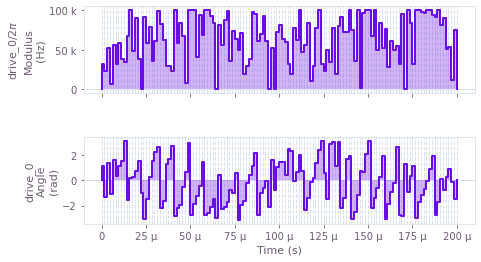

In [6]:
print(
    f"Resulting phases: \n {optimization_result.output['phases']['value']} \nTarget phases: \n {target_phases}"
)
print("Plot optimal control for ion 0:")
plot_controls(plt.figure(), {"drive_0": optimization_result.output["drive_0"]})

### Calculating trajectories for Mølmer–Sørensen gates

Q-CTRL also enables you to easily calculate the time trajectories of important physical properties of Mølmer–Sørensen gates, for example the mode displacement trajectories in phase space. You can utilize our flexible [`calculate_graph`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Functions/calculate_graph.html) function to track how phases, displacements, and infidelity change during the gate operational time by simply providing the `sample_times` parameter to the corresponding function, as demonstrated below.

Note that the results of the `ms_displacement` function describe contributions to each mode from each ion. To get the overall displacement for each mode, you need to sum over the ion dimension (see the notes of [`ms_displacements`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Operations/ms_displacements.html) for details).

In [7]:
sample_times = np.linspace(0, duration, 300)

with qctrl.create_graph() as graph:

    # Collect optimal controls from optimization
    optimal_drives = [
        qctrl.operations.tensor_pwc(
            durations=[v["duration"] for v in optimization_result.output[name]],
            values=[v["value"] for v in optimization_result.output[name]],
        )
        for name in drive_names
    ]

    phases = qctrl.operations.ms_phases(
        drives=optimal_drives,
        lamb_dicke_parameters=lamb_dicke_parameters,
        relative_detunings=relative_detunings,
        sample_times=sample_times,
        name="phases",
    )
    displacements = qctrl.operations.ms_displacements(
        drives=optimal_drives,
        lamb_dicke_parameters=lamb_dicke_parameters,
        relative_detunings=relative_detunings,
        sample_times=sample_times,
        name="displacements",
    )

    infidelity = qctrl.operations.ms_infidelity(
        phases=phases,
        displacements=displacements,
        target_phases=target_phases,
        name="infidelity",
    )

result = qctrl.functions.calculate_graph(
    graph=graph, output_node_names=["displacements", "infidelity", "phases"]
)

mode_displacements = np.sum(result.output["displacements"]["value"], axis=-1)

100%|██████████| 100/100 [00:03<00:00, 28.30it/s]


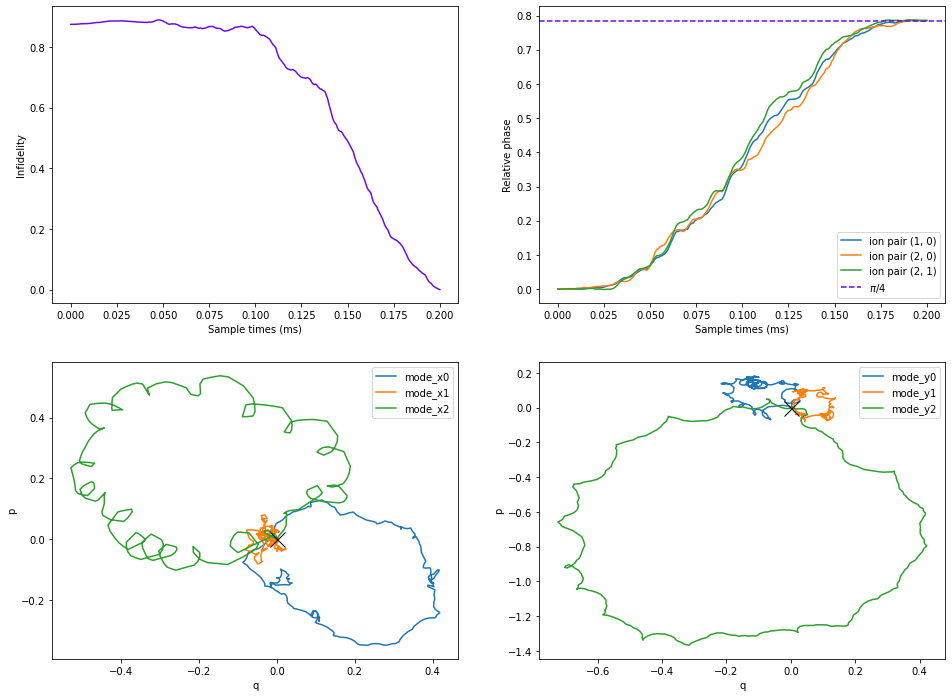

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0][0].plot(
    sample_times * 1e3, result.output["infidelity"]["value"], color="#680CEA"
)
axes[0][0].set_xlabel("Sample times (ms)")
axes[0][0].set_ylabel("Infidelity")

# Recall that the phases are stored as a strictly lower triangular matrix
# See the notes part of ms_phases
ion_pairs = []
for ion_1 in range(3):
    for ion_2 in range(ion_1):
        ion_pairs.append((ion_1, ion_2))
phases = result.output["phases"]["value"]

for (ion_1, ion_2) in ion_pairs:
    axes[0][1].plot(
        sample_times * 1e3, phases[:, ion_1, ion_2], label=f"ion pair {ion_1, ion_2}"
    )
# Target phase
axes[0][1].axhline(np.pi / 4, color="#680CEA", ls="--", label="$\pi/4$")
axes[0][1].legend()
axes[0][1].set_xlabel("Sample times (ms)")
axes[0][1].set_ylabel("Relative phase")

# Mode displacement trajectories for radial dimensions
for idx in range(ion_count):
    axes[1][0].plot(
        np.real(mode_displacements[:, 0, idx]),
        np.imag(mode_displacements[:, 0, idx]),
        label=f"mode_x{idx}",
    )
    axes[1][1].plot(
        np.real(mode_displacements[:, 1, idx]),
        np.imag(mode_displacements[:, 1, idx]),
        label=f"mode_y{idx}",
    )
# Displacement trajectories are expected to back to 0
# at the end of the drive as labelled by X here.
axes[1][0].plot(0, 0, marker="x", color="black", markersize=15)
axes[1][1].plot(0, 0, marker="x", color="black", markersize=15)
axes[1][0].legend()
axes[1][0].set_xlabel("q")
axes[1][0].set_ylabel("p")
axes[1][1].legend()
axes[1][1].set_xlabel("q")
axes[1][1].set_ylabel("p")
plt.show()

### Summary

In this example, you have seen how the Q-CTRL Python package can easily calculate the important physical properties for your ion trap, efficiently find optimal drives for state preparation, and track the ions states in phase space at any sample points during the gate operational time.

You can apply the same optimization strategy to large systems involving tens of qubits. This process is demonstrated in the [Cold ions: obtaining robust, configurable multi-qubit gates](https://docs.q-ctrl.com/boulder-opal/application-notes/cold-ions-obtaining-robust-configurable-multi-qubit-gates) Application note, where you will learn about how the Q-CTRL optimization engine enables you to efficiently find optimal and noise-robust control pulses for large trapped ion systems.

## Example: Robust control of trapped ions

Next we present an example showing how to prepare a Bell state for two ions affected by dephasing noise, which is common in experiments due to various noise sources, for example frequency fluctuations in control lasers. To find the robust control drives, you need to incorporate a symmetry constraint when setting up the drives and also add an extra term to the cost function quantifying robustness to the dephasing effect. A detailed discussion is given in [Bentley et al. (2020)](https://doi.org/10.1002/qute.202000044), and this robust control protocol to create the Bell state has also been recently demonstrated experimentally, as shown in [Milne et al. (2020)](https://doi.org/10.1103/PhysRevApplied.13.024022).

With the Q-CTRL Python package, you can use [`ms_dephasing_robust_cost`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Operations/ms_dephasing_robust_cost.html) to directly calculate the robust cost term  and use it in the Q-CTRL optimization engine to find the robust controls, following similar steps as shown in the previous worked example. The target relative phase between two ions is $\pi/4$. You can verify the robustness of the drives using quasi-static scans as shown in the [Cold ions: obtaining robust, configurable multi-qubit gates](https://docs.q-ctrl.com/boulder-opal/application-notes/cold-ions-obtaining-robust-configurable-multi-qubit-gates) Application note. 

100%|██████████| 100/100 [00:07<00:00, 13.90it/s]


Resulting phases: 
 [[0.         0.        ]
 [0.78540041 0.        ]] 
Target phases: 
 [[0.         0.        ]
 [0.78539816 0.        ]]
Plot optimal control for ion 0:


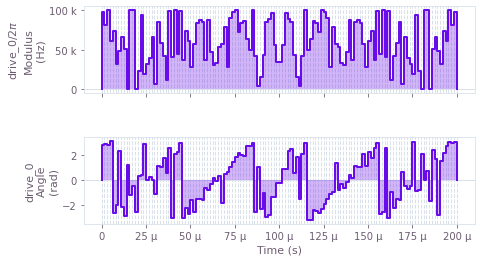

In [9]:
ion_count = 2
target_phases = np.array([[0, 0], [np.pi / 4, 0]])

# Calculate the ions properties
ion_chain_properties = qctrl.functions.calculate_ion_chain_properties(
    atomic_mass=atomic_mass,
    ion_count=ion_count,
    radial_x_center_of_mass_frequency=radial_x_center_of_mass_frequency,
    radial_y_center_of_mass_frequency=radial_y_center_of_mass_frequency,
    axial_center_of_mass_frequency=axial_center_of_mass_frequency,
    radial_x_wave_number=radial_x_wave_number,
    radial_y_wave_number=radial_y_wave_number,
    axial_wave_number=axial_wave_number,
)

# Collect Lamb Dicke parameters in the shape
# [<axis>, <collective_mode>, <ion>]
lamb_dicke_parameters = np.asarray(
    [
        [
            mode.lamb_dicke_parameters
            for mode in ion_chain_properties.radial_x_mode_properties
        ],
        [
            mode.lamb_dicke_parameters
            for mode in ion_chain_properties.radial_y_mode_properties
        ],
        [
            mode.lamb_dicke_parameters
            for mode in ion_chain_properties.axial_mode_properties
        ],
    ]
)

# Collect relative detunings in the shape
# [<axis>, <collective_mode>]
relative_detunings = (
    np.asarray(
        [
            [mode.frequency for mode in ion_chain_properties.radial_x_mode_properties],
            [mode.frequency for mode in ion_chain_properties.radial_y_mode_properties],
            [mode.frequency for mode in ion_chain_properties.axial_mode_properties],
        ]
    )
    - laser_detuning
)

# Helper function for generating symmetry drives
def reflect_signal(number_of_segments, phases, moduli):
    """
    This function reflects a drive signal about its temporal midpoint
    (Milne et al., Phys. Rev. Applied, 2020).
    The combined signal is returned.
    """
    phases_diff = phases[1:] - phases[:-1]
    if number_of_segments % 2 == 0:
        moduli_refl = qctrl.operations.reverse(moduli, [0])
        phases_diff_refl = qctrl.operations.concatenate(
            [np.array([0]), qctrl.operations.reverse(phases_diff, [0])],
            0,
        )
        phases_extra = phases[-1] + qctrl.operations.cumulative_sum(phases_diff_refl)
    else:
        moduli_refl = qctrl.operations.reverse(moduli[:-1], [0])
        phases_diff_refl = qctrl.operations.reverse(phases_diff, [0])
        phases_extra = phases[-1] + qctrl.operations.cumulative_sum(phases_diff_refl)

    moduli_comb = qctrl.operations.concatenate([moduli, moduli_refl], 0)
    phases_comb = qctrl.operations.concatenate([phases, phases_extra], 0)
    return moduli_comb, phases_comb


# Number of segments of the drives
segment_count = 128

# Total durations of the drives
duration = 2e-4

# Drive node names for retrieving the results
drive_names = ["drive_" + str(i) for i in range(ion_count)]

with qctrl.create_graph() as graph:

    # Specification of free variables and combination with reflected signal
    number_of_free_segments = int(np.ceil(segment_count / 2))

    drives = []
    for drive_name in drive_names:
        # The drive moduli are free variables here. They can also be restricted or fixed.
        drive_moduli = qctrl.operations.bounded_optimization_variable(
            count=number_of_free_segments,
            lower_bound=0,
            upper_bound=maximum_rabi_rate,
        )
        # The drive phases are free variables here. They can also be restricted or fixed.
        drive_phases = qctrl.operations.unbounded_optimization_variable(
            count=number_of_free_segments,
            initial_lower_bound=0,
            initial_upper_bound=2 * np.pi,
        )

        full_moduli, full_phases = reflect_signal(
            segment_count, drive_phases, drive_moduli
        )

        drives.append(
            qctrl.operations.complex_pwc_signal(
                moduli=full_moduli,
                phases=full_phases,
                duration=duration,
                name=drive_name,
            )
        )

    relative_phases = qctrl.operations.ms_phases(
        drives=drives,
        lamb_dicke_parameters=lamb_dicke_parameters,
        relative_detunings=relative_detunings,
        name="phases",
    )

    displacements = qctrl.operations.ms_displacements(
        drives=drives,
        lamb_dicke_parameters=lamb_dicke_parameters,
        relative_detunings=relative_detunings,
        name="displacements",
    )

    robust_cost_term = qctrl.operations.ms_dephasing_robust_cost(
        drives=drives,
        lamb_dicke_parameters=lamb_dicke_parameters,
        relative_detunings=relative_detunings,
    )

    infidelity = qctrl.operations.ms_infidelity(
        phases=relative_phases,
        displacements=displacements,
        target_phases=target_phases,
        name="infidelity",
    )

    cost = infidelity + robust_cost_term
    cost.name = "cost"

optimization_result = qctrl.functions.calculate_optimization(
    cost_node_name="cost",
    output_node_names=["phases"] + drive_names,
    graph=graph,
)

# Show results
print(
    f"Resulting phases: \n {optimization_result.output['phases']['value']} \nTarget phases: \n {target_phases}"
)
print("Plot optimal control for ion 0:")
plot_controls(plt.figure(), {"drive_0": optimization_result.output["drive_0"]})